<a href="https://colab.research.google.com/github/ms0017/GANs_exploration/blob/master/GANs_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount G-Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Next, clone StyleGAN2 ADA PyTorch from GitHub.
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


In [ ]:
#Verify that StyleGAN has been cloned.
!ls /content/stylegan2-ada-pytorch/

calc_metrics.py  docker_run.sh	LICENSE.txt   README.md        train.py
dataset_tool.py  docs		metrics       style_mixing.py
dnnlib		 generate.py	projector.py  torch_utils
Dockerfile	 legacy.py	__pycache__   training


In [ ]:
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy
from tqdm.notebook import tqdm

In [ ]:
# takes short seed numbers "seed" eg 6600 and expand them into a 512 latent vector, which is a floating point value
# The seed value is easier to represent in code than a 512 value vector. However, while a small change to the latent vector 
# results in a small change to the image, even a small change to the seed value will produce a radically different image.
# Can think of the latent vector as the DNA
def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

# G: Neural Net
# z: 512 lantent vectors/ seeds
# truncation_psi: used by stylegan2 to make images clearer
def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label


def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

def expand_seed(seeds, vector_size):
  result = []
  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

def download_torch_pretrained_instance(device):
  #URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
  #URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
  #URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
  URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
  print(f'Loading networks from "{URL}"...')
  with dnnlib.util.open_url(URL) as f:
      G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
  return G

def get_images(G, device):
  # Choose your own starting and ending seed.
  SEED_FROM = 2000
  SEED_TO = 2003

  # Generate the images for the seeds.
  for i in range(SEED_FROM, SEED_TO):
    print(f"Seed {i}")
    z = seed2vec(G, i)
    img = generate_image(device, G, z)
    display_image(img)

def explore_seed(G):
  vector_size = G.z_dim
  # range(8192,8300)
  seeds = expand_seed( [8192+1,8192+9], vector_size)
  #generate_images(Gs, seeds,truncation_psi=0.5)
  print(seeds[0].shape)

def morph_video(G, device):
  # Choose your seeds to morph through and the 
  # number of steps to take to get to each.
  SEEDS = [2000,2003,2001]
  STEPS = 100

  # Remove any prior results
  !rm /content/results/* 
  os.makedirs("./results/", exist_ok=True)

  # Generate the images for the video.
  idx = 0
  for i in range(len(SEEDS)-1):
    v1 = seed2vec(G, SEEDS[i])
    v2 = seed2vec(G, SEEDS[i+1])

    diff = v2 - v1
    step = diff / STEPS
    current = v1.copy()

    for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
      current = current + step
      img = generate_image(device, G, current)
      img.save(f'./results/frame-{idx}.png')
      idx+=1
  
  # Link the images into a video.
  !ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

def download_video():
  from google.colab import files
  files.download('movie.mp4')

def driver():
    device = torch.device('cuda')
    G = download_torch_pretrained_instance(device)
    get_images(G, device)
    explore_seed(G)
    morph_video(G, device)
    download_video()

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Seed 2000


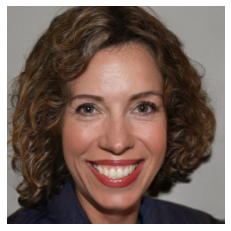

Seed 2001


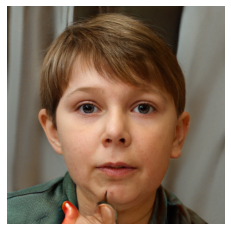

Seed 2002


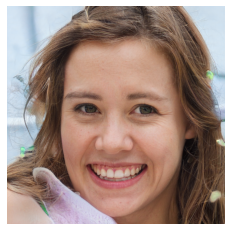

(1, 512)
rm: cannot remove '/content/results/*': No such file or directory



ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
driver()